In [12]:
# 自动计算cell的计算时间
%load_ext autotime

%config InlineBackend.figure_format='svg' #矢量图设置，让绘图更清晰

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 16.3 ms (started: 2021-08-12 23:15:23 +08:00)


In [2]:
%%bash

# 增加更新
git add *.ipynb

git remote -v

git commit -m '更新 ch4 #3 change Aug 12, 2021'

git push origin master

origin	git@github.com:ustchope/Advanced-Deep-Learning-with-Keras.git (fetch)
origin	git@github.com:ustchope/Advanced-Deep-Learning-with-Keras.git (push)
[master 8db3e23] 更新 ch4 #2 change Aug 12, 2021
 1 file changed, 13774 insertions(+), 872 deletions(-)
 rewrite ch4.ipynb (68%)


To git@github.com:ustchope/Advanced-Deep-Learning-with-Keras.git
   0742a64..8db3e23  master -> master


time: 5.12 s (started: 2021-08-12 22:47:35 +08:00)


In [13]:
#设置使用的gpu
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
   
    gpu0 = gpus[0] #如果有多个GPU，仅使用第0个GPU
    tf.config.experimental.set_memory_growth(gpu0, True) #设置GPU显存用量按需使用
    # 或者也可以设置GPU显存为固定使用量(例如：4G)
    #tf.config.experimental.set_virtual_device_configuration(gpu0,
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) 
    tf.config.set_visible_devices([gpu0],"GPU")

time: 1.08 ms (started: 2021-08-12 23:15:26 +08:00)


# 生成对抗网络 (GAN)

在本章中，我们将研究生成对抗网络 (GAN)。 GAN 属于生成模型家族。 然而，与自动编码器不同，生成模型能够在给定任意编码的情况下创建新的、有意义的输出。

在本章中，将讨论 GAN 的工作原理。 我们还将回顾使用 tf.keras 的几个早期 GAN 的实现，而在本章的后面，我们将演示实现稳定训练所需的技术。 本章的范围涵盖了 GAN 实现的两个流行示例，深度卷积 GAN (DCGAN) 和条件 GAN (CGAN)。

总之，本章的目标是：
* 介绍 GAN 的原理
* 展示 GAN 的早期工作实现之一，称为DCGAN
* 一种称为 CGAN 的改进 DCGAN，它使用条件
* 在 tf.keras 中实现 DCGAN 和 CGAN

让我们从 GAN 的概述开始。

## GAN 概述

在我们进入 GAN 的更高级概念之前，让我们先回顾一下 GAN 并介绍它们背后的基本概念。 GAN 非常强大； 这个简单的陈述得到了以下事实的证明：它们可以通过执行潜在空间插值来生成不是真人的新人脸。

在这些 YouTube 视频中可以看到 GAN 的高级功能：
* 渐进式 GAN [4]：https://youtu.be/G06dEcZ-QTg
* StyleGAN v1 [5]：https://youtu.be/kSLJriaOumA
* StyleGAN v2 [6]：https://youtu.be/c-NJtV9Jvp0

展示如何利用 GAN 生成逼真人脸的视频展示了它们的强大功能。这个主题比我们之前在本书中看到的任何内容都要先进得多。例如，上面的视频演示了自动编码器无法轻松完成的事情，我们在第 3 章，自动编码器中介绍了这些内容。

GAN 能够通过训练两个被称为生成器和鉴别器（有时称为评论家）的竞争（和合作）网络来学习如何对输入分布进行建模。生成器的作用是不断弄清楚如何生成可以欺骗鉴别器的虚假数据或信号（包括音频和图像）。同时，鉴别器被训练来区分假信号和真实信号。随着训练的进行，判别器将不再能够看到合成生成的数据和真实数据之间的差异。从那里，可以丢弃鉴别器，然后可以使用生成器来创建以前从未观察到的新的真实数据。

GAN 的基本概念很简单。 然而，我们会发现的一件事是，最具挑战性的问题是我们如何实现生成器-鉴别器网络的稳定训练？ 生成器和鉴别器之间必须存在良性竞争，以便两个网络能够同时学习。 由于损失函数是根据鉴别器的输出计算的，因此其参数更新很快。 当判别器收敛得更快时，生成器不再为其参数接收足够的梯度更新并且无法收敛。 除了难以训练之外，GAN 还可能遭受部分或全部模态崩溃，在这种情况下，生成器为不同的潜在编码产生几乎相似的输出。

### GANs原理

如图 4.1.1 所示，GAN 类似于造假者（生成器）-警察（鉴别器）的场景。 在学院里，警察被教导如何确定一美元钞票是真还是假。 来自银行的真美元钞票样本和来自伪造者的假币样本被用来训练警察。 然而，有时，造假者会试图假装他印的是真钞票。 最初，警察不会上当，会告诉造假者为什么钱是假的。 考虑到这种反馈，造假者再次磨练自己的技能，并试图制造新的假美元钞票。 正如预期的那样，警方将能够发现这些钱是假的，并证明美元钞票是假的：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gte4futnx5j618q0u079802.jpg)

这个过程会无限期地持续下去，但最终造假者已经掌握了制造假币的能力，以至于假币与真钱无法区分——即使是最专业的警察也是如此。 然后，造假者可以无限印刷美元钞票而不会被警察抓住，因为它们不再被识别为伪造品。

如图 4.1.2 所示，一个 GAN 由两个网络组成，一个生成器和一个判别器：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gte4j3gtpdj61ag0ooju302.jpg)

发生器的输入是噪声，输出是合成数据。同时，鉴别器的输入将是真实数据或合成数据。真实数据来自真实采样数据，而假数据来自生成器。所有有效数据都标记为 1.0（即 100% 的真实概率），而所有合成数据都标记为 0.0（即真实概率为 0%）。由于标记过程是自动化的，GAN 仍然被认为是深度学习中无监督学习方法的一部分。

鉴别器的目标是从这个提供的数据集中学习如何区分真实数据和虚假数据。在这部分 GAN 训练期间，只会更新鉴别器参数。与典型的二元分类器一样，鉴别器被训练以在 0.0 到 1.0 的范围内预测给定输入数据与真实数据的接近程度。然而，这只是故事的一半。

每隔一段时间，生成器会假装其输出是真实数据，并要求 GAN 将其标记为 1.0。当假数据被呈现给鉴别器时，自然会被归类为标签接近 0.0 的假数据。

优化器根据显示的标签（即 1.0）计算生成器参数更新。在对这些新数据进行训练时，它还考虑了自己的预测。换句话说，判别器对其预测有一些怀疑，因此，GAN 会考虑到这一点。这一次，GAN 会让梯度从鉴别器的最后一层向下传播到生成器的第一层。然而，在大多数实践中，在这个训练阶段，鉴别器参数会被暂时冻结。生成器将使用梯度更新其参数并提高其合成假数据的能力。

总的来说，整个过程类似于两个网络相互竞争，同时仍然合作。当 GAN 训练收敛时，最终结果是一个可以合成看起来真实的数据的生成器。鉴别器认为这个合成数据是真实的或者标签接近 1.0，这意味着鉴别器可以被丢弃。发生器部分将有助于从任意噪声输入产生有意义的输出。

下面的图 4.1.3 概述了该过程：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gte4nf7lqvj61as0m0gon02.jpg)

如上图所示，可以通过最小化以下等式中的损失函数来训练判别器：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gte4rsbhgzj618004cwet02.jpg)

该方程只是标准的二元交叉熵成本函数。 损失是正确识别真实数据的期望值 𝒟(𝒙) 和 1.0 减去正确识别合成数据的期望值 1 − 𝒟(𝒢(𝒛)) 的负和。 日志不会更改局部最小值的位置。

训练期间向判别器提供两个小批量数据：
1. x，来自采样数据的真实数据（换句话说，$𝒙 \sim p_{data}$），标签为 1.0
2. 𝒙′ = 𝒢(𝒛)，来自生成器的假数据，标签为 0.0

为了最小化损失函数，鉴别器参数 𝜽(𝐷) 将通过反向传播通过正确识别真实数据 𝒟(𝒙) 和合成数据 1 − 𝒟(𝒢(𝒛)) 进行更新。 正确识别真实数据相当于 𝒟(𝒙) → 1.0，而正确识别虚假数据相当于 𝒟(𝒢(𝒛)) → 0.0 或 (1 − 𝒟(𝒢(𝒛))) → 1.0。 在这个等式中，z 是生成器用来合成新信号的任意编码或噪声向量。 两者都有助于最小化损失函数。

为了训练生成器，GAN 将鉴别器和生成器损失的总和视为零和游戏。 生成器损失函数只是判别器损失函数的负值：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gte5dpon0rj617u0420sv02.jpg)

然后可以更恰当地将其重写为值函数：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gte5h7dz59j617o03gt8u02.jpg)

从生成器的角度来看，公式 4.1.3 应该最小化。 从判别器的角度来看，应该最大化价值函数。 因此，生成器训练准则可以写成一个极大极小问题：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gte5i3hssoj617i04074h02.jpg)

有时，我们会假装合成数据是真实的，标签为 1.0，以此来欺骗鉴别器。 通过最大化 𝜽(𝐷)，优化器向鉴别器参数发送梯度更新，以将这些合成数据视为真实数据。 同时，通过关于 𝜽(𝐺) 的最小化，优化器将训练生成器的参数如何欺骗鉴别器。 然而，在实践中，鉴别器对其将合成数据分类为假数据的预测充满信心，并且不会更新 GAN 参数。 此外，梯度更新很小，并且随着它们传播到生成器层而显着减少。 结果，生成器无法收敛。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gte5kt2i6kj61c60kkgnw02.jpg)

解决方案是将生成器的损失函数重新表述为以下形式：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gte5lllabvj619203u3yn02.jpg)

损失函数只是通过训练生成器来最大化鉴别器相信合成数据是真实的机会。新公式不再是零和，而是纯粹的启发式驱动。图 4.1.4 显示了训练期间的生成器。在这个图中，生成器参数只有在整个对抗网络都被训练时才会更新。这是因为梯度从鉴别器传递到生成器。然而，在实践中，鉴别器权重只是在对抗训练期间暂时冻结。

在深度学习中，生成器和鉴别器都可以使用合适的神经网络架构来实现。如果数据或信号是图像，生成器和鉴别器网络都将使用 CNN。对于音频等一维序列，两个网络通常都是循环的（RNN、LSTM 或 GRU）。

在本节中，我们了解到 GAN 背后的原理很简单。我们还学习了如何通过熟悉的网络层实现 GAN。 GAN 与其他网络的不同之处在于它们很难训练。像层中的微小变化这样简单的事情就会导致网络训练不稳定。在下一节中，我们将研究使用深度 CNN 的 GAN 早期成功实现之一。它被称为 DCGAN [3]。

## 在 Keras 中实现 DCGAN

图 4.2.1 显示了用于生成假 MNIST 图像的 DCGAN：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gte5po6v6yj61840u0q5y02.jpg)

DCGAN 实现了以下设计原则：
* 使用strides > 1 和卷积而不是MaxPooling2D 或UpSampling2D。 随着步幅 > 1，CNN 学习如何调整特征图的大小。
* 避免使用密集层。 在所有层中使用 CNN。 密集层仅用作生成器的第一层以接受 z 向量。 Dense 层的输出被调整大小并成为后续 CNN 层的输入。
* 使用批量归一化 (BN) 通过将每一层的输入归一化为零均值和单位方差来稳定学习。 生成器输出层和鉴别器输入层没有BN。 在此处介绍的实现示例中，鉴别器中没有使用批量归一化。
* 整流线性单元 (ReLU) 用于生成器的所有层，输出层除外，其中使用了 tanh 激活。 在此处介绍的实现示例中，在生成器的输出中使用 sigmoid 代替 tanh，因为它通常会导致对 MNIST 数字的更稳定的训练。
* 在鉴别器的所有层中使用Leaky ReLU。 与 ReLU 不同的是，Leaky ReLU 不会在输入小于零时将所有输出归零，而是生成一个与 alpha x 输入相等的小梯度。 在以下示例中，alpha = 0.2。

生成器学习从 100 维输入向量（[-1.0, 1.0] 范围内 100 维均匀分布的随机噪声）生成假图像。鉴别器将真实图像与虚假图像进行分类，但在训练对抗网络时无意中指导生成器如何生成真实图像。我们的 DCGAN 实现中使用的内核大小为 5。这是为了增加卷积的感受野大小和表达能力。

生成器接受由范围为 -1.0 到 1.0 的均匀分布生成的 100 维 z 向量。生成器的第一层是一个 7 x 7 x 128 = 6,272 单元的 Dense 层。单位数是根据输出图像的预期最终尺寸（28 x 28 x 1，28 是 7 的倍数）和第一个 Conv2DTranspose 的滤波器数量计算的，该数量等于 128。

我们可以将转置 CNN（Conv2DTranspose）想象成 CNN 的逆过程。在一个简单的例子中，如果 CNN 将图像转换为特征图，则转置的 CNN 将生成给定特征图的图像。因此，前一章的解码器和本章的生成器都使用了转置 CNN。

> 清单 4.2.1：dcgan-mnist-4.2.1.py

In [20]:
'''Trains DCGAN on MNIST using Keras

DCGAN 是使用 CNN 的生成对抗网络 (GAN)。 生成器试图通过生成假图像来欺骗鉴别器。 
鉴别器学习区分真假图像。 生成器+鉴别器形成对抗网络。 DCGAN 交替训练鉴别器和对抗网络。 
在训练期间，鉴别器不仅学习区分真假图像，还指导对抗的生成器部分如何提高其生成假图像的能力。

[1] Radford, Alec, Luke Metz, and Soumith Chintala.
"Unsupervised representation learning with deep convolutional
generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).
'''


from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model

from tensorflow.keras import layers


import numpy as np
import math
import matplotlib.pyplot as plt
import os
import argparse


def build_generator(inputs, image_size):
    """Build a Generator Model

    BN-ReLU-Conv2DTranpose堆栈生成假图像
    输出激活是 sigmoid 而不是 [1] 中的 tanh。
    Sigmoid 很容易收敛。

    参数：
         输入（层）：生成器的输入层，z 向量）
         image_size（张量）：一侧的目标大小，（假设方形图像）

    Returns:
        generator (Model): Generator Model
    """

    image_resize = image_size // 4
    # network parameters 
    kernel_size = 5
    layer_filters = [128, 64, 32, 1]

    x = Dense(image_resize * image_resize * layer_filters[0])(inputs)
    x = Reshape((image_resize, image_resize, layer_filters[0]))(x)

    for filters in layer_filters:
        # 前两个卷积层使用 strides = 2
        # 最后两个使用strides = 1
        if filters > layer_filters[-2]:
            strides = 2
        else:
            strides = 1
        x = BatchNormalization()(x)
        x = layers.LeakyReLU()(x)
#         x = Activation('relu')(x)
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=strides,
                            padding='same')(x)
#         x = layers.LeakyReLU()(x)

#     x = Activation('sigmoid')(x)
    x = layers.LeakyReLU()(x)
    generator = Model(inputs, x, name='generator')
#     generator.summary()
    return generator

time: 2.26 ms (started: 2021-08-12 23:20:24 +08:00)


In [21]:
from tensorflow.keras import layers
build_generator(layers.Input(shape=(100,)), 28).summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_7 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_5 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_20 (Conv2DT (None, 14, 14, 128)       409728    
_________________________________________________________________
batch_normalization_21 (Batc (None, 14, 14, 128)       51

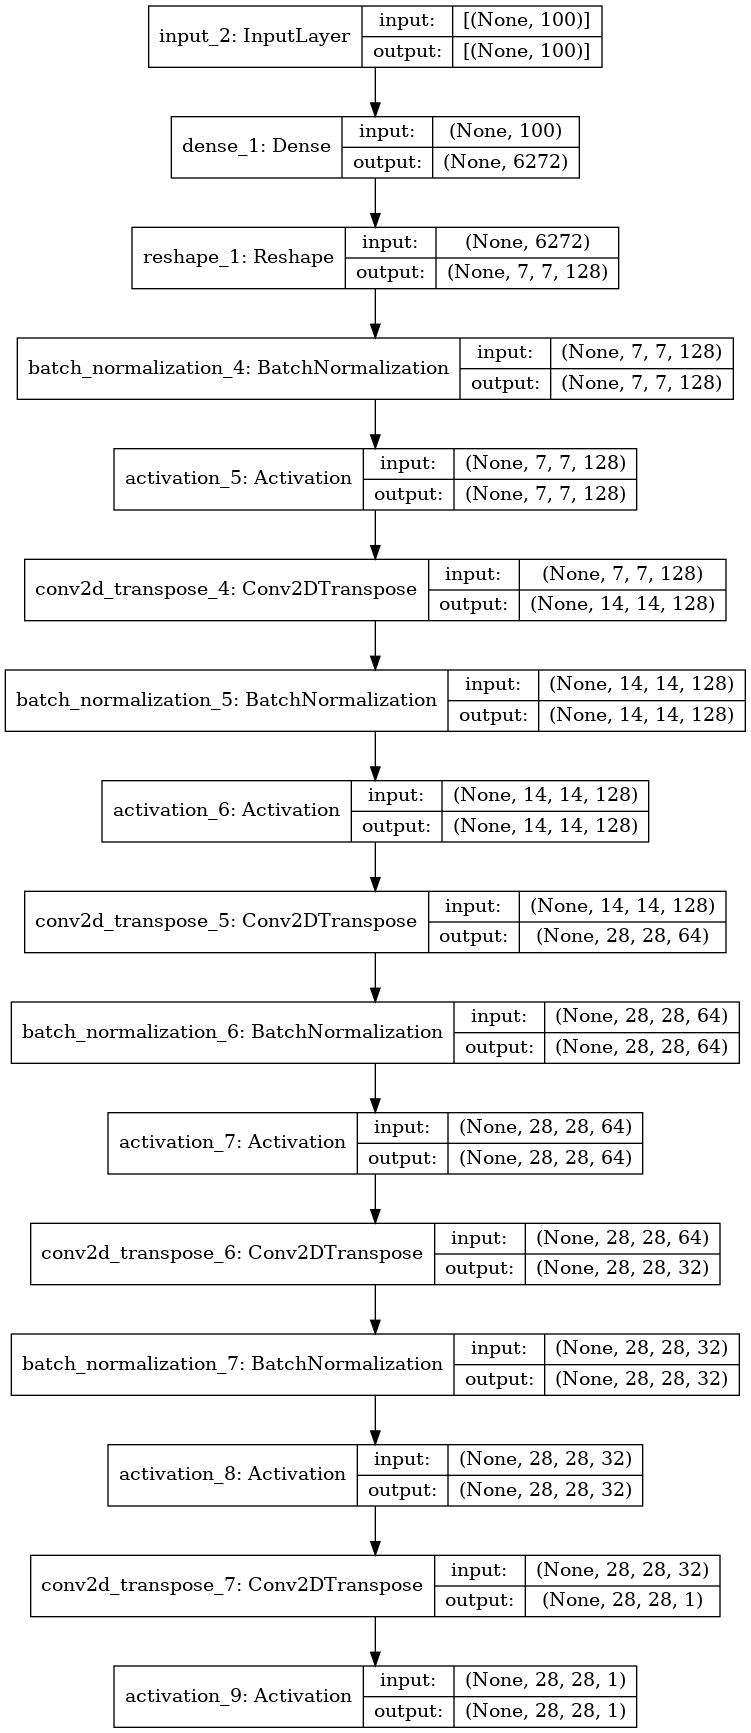

time: 531 ms (started: 2021-08-12 22:48:03 +08:00)


In [6]:
from tensorflow.keras.utils import plot_model
plot_model(build_generator(layers.Input(shape=(100,)), 28), show_shapes = True)

In [26]:
def build_discriminator(inputs):
    """Build a Discriminator Model

    用于区分真假的 LeakyReLU-Conv2D 堆栈。
     网络不与 BN 收敛所以这里不使用
     与 [1] 或原始论文不同。

     参数：
         输入（层）：鉴别器的输入层（图像）

    Returns:
        discriminator (Model): Discriminator Model
    """
    kernel_size = 5
    layer_filters = [32, 64, 128, 256]

    x = inputs
    for filters in layer_filters:
        # first 3 convolution layers use strides = 2
        # last one uses strides = 1
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same')(x)

    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    discriminator = Model(inputs, x, name='discriminator')
    return discriminator

time: 1.7 ms (started: 2021-08-12 23:23:25 +08:00)


In [27]:
build_discriminator(layers.Input(shape=(28,28,1))).summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 28, 28, 1)         4         
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
batch_normalization_27 (Batc (None, 14, 14, 32)        128       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 64)        

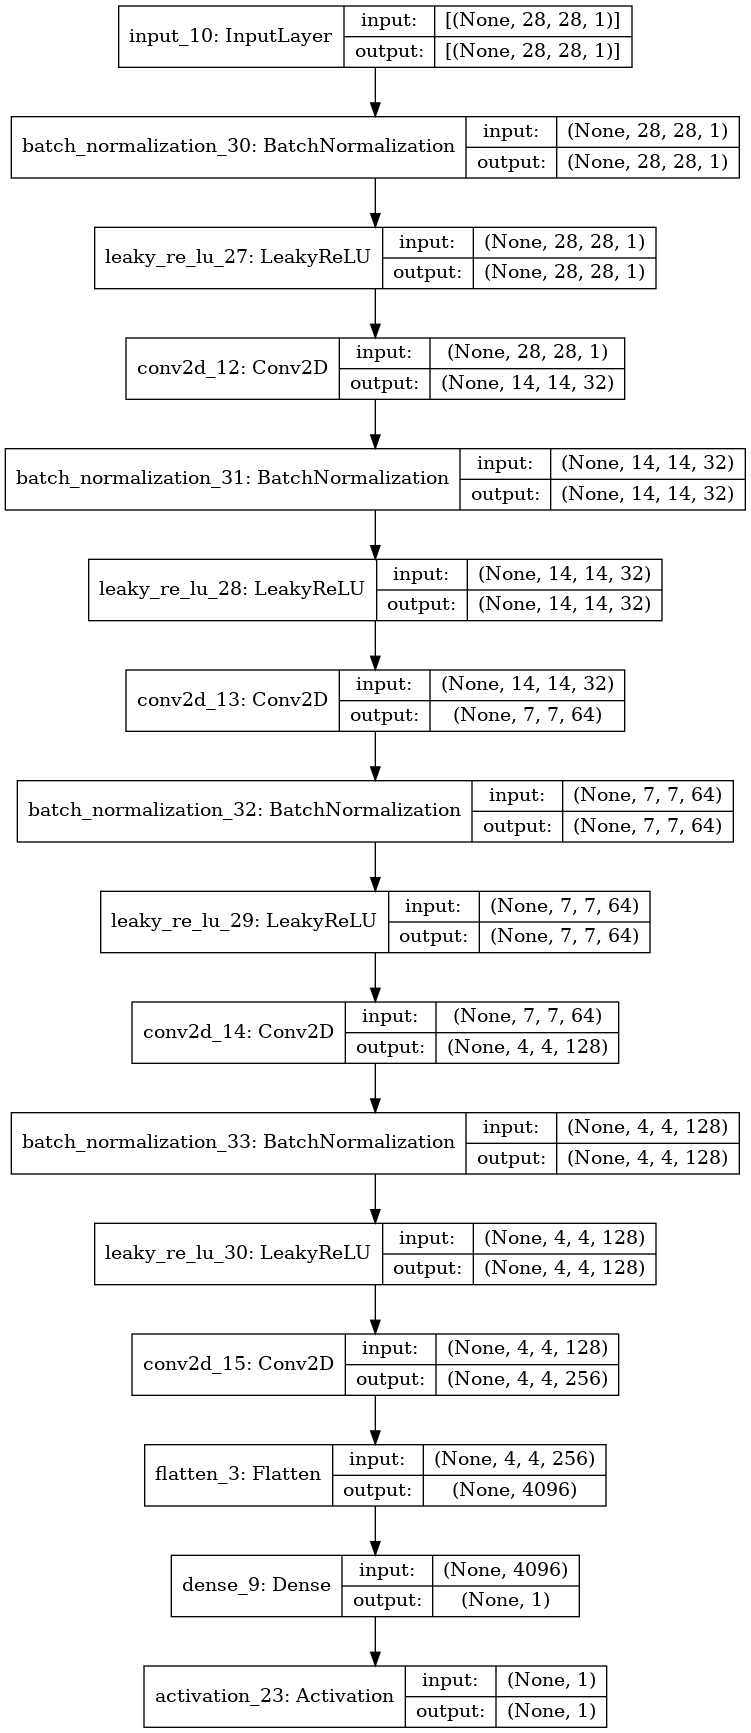

time: 680 ms (started: 2021-08-12 23:23:31 +08:00)


In [28]:
plot_model(build_discriminator(layers.Input(shape=(28,28,1))), show_shapes = True)

In [29]:
def train(models, x_train, params):
    """Train the Discriminator and Adversarial Networks

    交替训练判别器和对抗网络。
    首先用正确的真假图像训练鉴别器。
    接下来用假装是真实的假图像训练对抗
    每个 save_interval 生成示例图像。

    Arguments:
        models (list): Generator, Discriminator, Adversarial models
        x_train (tensor): Train images
        params (list) : Networks parameters

    """
    # the GAN component models
    generator, discriminator, adversarial = models
    # network parameters
    batch_size, latent_size, train_steps, model_name = params
    # the generator image is saved every 500 steps
    save_interval = 500
    # noise vector to see how the generator output evolves during training
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
    # number of elements in train dataset
    train_size = x_train.shape[0]
    for i in range(train_steps):
        
        # 训练 1 个批次的鉴别器
        # 1 批真实（标签=1.0）和假图像（标签=0.0）
        # 从数据集中随机选择真实图像
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]
        # generate fake images from noise using generator 
        # generate noise using uniform distribution
        noise = np.random.uniform(-1.0,
                                  1.0,
                                  size=[batch_size, latent_size])
        # generate fake images
        fake_images = generator.predict(noise)
        # real + fake images = 1 batch of train data
        x = np.concatenate((real_images, fake_images))
        # label real and fake images
        # real images label is 1.0
        y = np.ones([2 * batch_size, 1])
        # fake images label is 0.0
        y[batch_size:, :] = 0.0
        # 训练鉴别器网络，记录损失和准确性
        loss, acc = discriminator.train_on_batch(x, y)
        log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)

        # 训练 1 个批次的对抗网络
        # 1 批带有 label=1.0 的假图像
        # 因为判别器权重被冻结在对抗网络中
        # 只使用均匀分布生成噪声训练生成器
        noise = np.random.uniform(-1.0,
                                  1.0, 
                                  size=[batch_size, latent_size])
        # label fake images as real or 1.0
        y = np.ones([batch_size, 1])
        # 训练对抗网络
        # 请注意，与判别器训练不同，
        # 我们不将假图像保存在变量中
        # 假图像进入对抗的鉴别器输入
        # 用于分类
        # 记录损失和准确率
        loss, acc = adversarial.train_on_batch(noise, y)
        log = "%s [adversarial loss: %f, acc: %f]" % (log, loss, acc)
        print(log)
        if (i + 1) % save_interval == 0:
            # plot generator images on a periodic basis
            plot_images(generator,
                        noise_input=noise_input,
                        show=False,
                        step=(i + 1),
                        model_name=model_name)
   
    # 训练生成器后保存模型
    # 训练好的生成器可以重新加载
    # 未来的 MNIST 数字生成
    generator.save(model_name + ".h5")

time: 2.49 ms (started: 2021-08-12 23:23:38 +08:00)


In [30]:
def plot_images(generator,
                noise_input,
                show=False,
                step=0,
                model_name="gan"):
    """Generate fake images and plot them
        出于可视化目的，生成假图像
        然后将它们绘制在方形网格中

        参数：
            generator（Model）：用于生成假图像的生成器模型
            noise_input (ndarray)：z 向量数组
            show (bool): 是否显示情节
            step（int）：附加到保存图像的文件名
            model_name（string）：模型名称

    """
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "%05d.png" % step)
    images = generator.predict(noise_input)
    plt.figure(figsize=(2.2, 2.2))
    num_images = images.shape[0]
    image_size = images.shape[1]
    rows = int(math.sqrt(noise_input.shape[0]))
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.savefig(filename)
    if show:
        plt.show()
    else:
        plt.close('all')

time: 1.34 ms (started: 2021-08-12 23:23:40 +08:00)


In [ ]:
def build_and_train_models():
    # load MNIST dataset
    (x_train, _), (_, _) = mnist.load_data()

    # reshape data for CNN as (28, 28, 1) and normalize
    image_size = x_train.shape[1]
    x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
    x_train = x_train.astype('float32') / 255

    model_name = "dcgan_mnist"
    # network parameters
    # the latent or z vector is 100-dim
    latent_size = 100
    batch_size = 64
    train_steps = 40000
    lr = 2e-4
    decay = 6e-8
    input_shape = (image_size, image_size, 1)

    # build discriminator model
    inputs = Input(shape=input_shape, name='discriminator_input')
    discriminator = build_discriminator(inputs)
    # [1] or original paper uses Adam, 
    # but discriminator converges easily with RMSprop
    optimizer = RMSprop(learning_rate=lr, decay=decay)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
    discriminator.summary()

    # build generator model
    input_shape = (latent_size, )
    inputs = Input(shape=input_shape, name='z_input')
    generator = build_generator(inputs, image_size)
    generator.summary()

    # build adversarial model
    optimizer = RMSprop(learning_rate=lr * 0.5, decay=decay * 0.5)
    # 在对抗训练期间冻结鉴别器的权重
    discriminator.trainable = False
    # adversarial = generator + discriminator
    adversarial = Model(inputs, 
                        discriminator(generator(inputs)),
                        name=model_name)
    adversarial.compile(loss='binary_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])
    adversarial.summary()

    # train discriminator and adversarial networks
    models = (generator, discriminator, adversarial)
    params = (batch_size, latent_size, train_steps, model_name)
    train(models, x_train, params)


def test_generator(generator):
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
    plot_images(generator,
                noise_input=noise_input,
                show=True,
                model_name="test_outputs")

    
run_generator =False

if __name__ == '__main__':
#    parser = argparse.ArgumentParser()
#    help_ = "Load generator h5 model with trained weights"
#    parser.add_argument("-g", "--generator", help=help_)
#    args = parser.parse_args()
    if run_generator:
        generator = load_model(model_name)
        test_generator(generator)
    else:
        build_and_train_models()
        

# if __name__ == '__main__':
# #    parser = argparse.ArgumentParser()
# #    help_ = "Load generator h5 model with trained weights"
# #    parser.add_argument("-g", "--generator", help=help_)
# #    args = parser.parse_args()
#     if args.generator:
#         generator = load_model(args.generator)
#         test_generator(generator)
#     else:
#         build_and_train_models()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa [(None, 28, 28, 1)]       0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 28, 28, 1)         4         
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 32)        832       
_________________________________________________________________
batch_normalization_35 (Batc (None, 14, 14, 32)        128       
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 7, 64)        